In [ ]:
import openl3
import demucs
from demucs import pretrained
from demucs.apply import apply_model
import torch
import torchaudio
from demucs.pretrained import get_model
from demucs.audio import AudioFile
from demucs.separate import apply_model
import numpy as np
from pydub import AudioSegment
from demucs import pretrained
from demucs.apply import apply_model
from sentence_transformers import SentenceTransformer, util
from transformers import CLIPTokenizer, CLIPTextModel
import torch.nn as nn
from diffusers import StableDiffusionPipeline


In [ ]:
class AudioImageGenerator:
    def __init__(self, song_path, lyrics, export_path):
        self.song_path = song_path
        self.lyrics = lyrics
        self.export_path = export_path
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.text_model = SentenceTransformer(
            "all-MiniLM-L6-v2",
            device=self.device
        )

        self.tokenizer = CLIPTokenizer.from_pretrained(
            "openai/clip-vit-large-patch14"
        )
        self.text_encoder = CLIPTextModel.from_pretrained(
            "openai/clip-vit-large-patch14"
        ).to(self.device)
    def extract_audio_embedding(self):
        song = AudioSegment.from_mp3(self.song_path)
        sr = song.frame_rate
        samples = np.array(song.get_array_of_samples(), dtype=np.float32)

        if song.channels == 2:
            samples = samples.reshape((-1, 2))
        else:
            samples = samples.reshape((-1, 1))

        wav = torch.from_numpy(samples.T).unsqueeze(0).to(self.device)

        model = pretrained.get_model("htdemucs")
        model.to(self.device).eval()

        estimates = apply_model(model, wav, device=self.device, split=True)
        estimates = estimates[0]

        stem_names = ["vocals", "drums", "bass", "other"]
        stems_np = []

        for stem in estimates:
            stem_np = stem.detach().cpu().numpy().T
            if stem_np.shape[1] == 1:
                stem_np = stem_np[:, 0]
            stems_np.append(stem_np)

        openl3_model = openl3.models.load_audio_embedding_model(
            input_repr="mel128",
            content_type="music",
            embedding_size=512
        )

        collapsed = []
        for stem_audio in stems_np:
            emb, _ = openl3.get_audio_embedding(
                audio=stem_audio,
                sr=sr,
                model=openl3_model,
                hop_size=0.1
            )
            collapsed.append(np.concatenate([
                emb.mean(axis=0),
                emb.std(axis=0)
            ]))

        audio_vec = np.concatenate(collapsed)
        audio_vec = audio_vec / np.linalg.norm(audio_vec)

        return torch.tensor(audio_vec, dtype=torch.float32)
    def get_lyric_token_embeddings(self):
        tokens = self.tokenizer(
            self.lyrics,
            padding="max_length",
            truncation=True,
            max_length=77,
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            text_embeddings = self.text_encoder(**tokens).last_hidden_state

        return text_embeddings
    def fuse_audio_and_text(self, text_embeddings, audio_vec):
        audio_to_clip = nn.Linear(audio_vec.shape[0], 768, bias=False)
        nn.init.normal_(audio_to_clip.weight, std=0.01)

        audio_bias = audio_to_clip(audio_vec)
        audio_bias = audio_bias.unsqueeze(0).unsqueeze(0)

        fused = text_embeddings + 0.5 * audio_bias
        return fused.cpu()
    def generate_image(self, fused_embeddings):
        pipe = StableDiffusionPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            torch_dtype=torch.float32
        ).to("cpu")

        pipe.safety_checker = None
        pipe.enable_attention_slicing()

        image = pipe(
            prompt_embeds=fused_embeddings,
            guidance_scale=0.0,
            num_inference_steps=75
        ).images[0]

        image.save(self.export_path)
        return image
    def run(self):
        audio_vec = self.extract_audio_embedding()
        text_embeddings = self.get_lyric_token_embeddings()
        fused = self.fuse_audio_and_text(text_embeddings, audio_vec)
        return self.generate_image(fused)

In [ ]:
gen = AudioImageGenerator(
    song_path=f'/{"Path to song in mp3 format"}.mp3',
    lyrics=f'''
{"Paste song lyrics"}
''',
    export_path=f"{"Output path for song in PNG format"}.png"
)
image = gen.run()

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1182.84it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Loading weights: 100%|██████████| 196/196 [00:00<00:00, 2098.98it/s, Materializing param=text_model.final_layer_norm.weight]                    
CLIPTextModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                                            | Status     |  | 
---------------------------------------------------------------+------------+--+-
vision_model.encoder.layers.{0...23}.self_attn.v_proj.bias     | UNEXPECTED |  | 
vision_model.encoder.layers.{0...23}.self_attn.k_proj.weight   | UNEXPECTED |  | 
vision_mo

71/71 ━━━━━━━━━━━━━━━━━━━━ 46s 633ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 617ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 620ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 618ms/step


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading weights: 100%|██████████| 196/196 [00:00<00:00, 730.99it/s, Materializing param=text_model.final_layer_norm.weight]
CLIPTextModel LOAD REPORT from: /Users/paigecaskey/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Loading weights: 100%|██████████| 396/396 [00:00<00:00, 625.32it/s, Materializing param=visual_projection.weight]


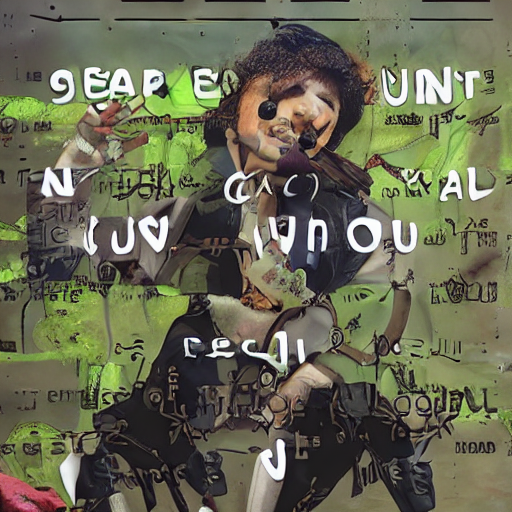

In [57]:
display(image)